# Gmail Analysis

## Importing and loading

In [7]:
# First, we need to install some libraries 

   !{sys.executable} -m pip install httplib2
   !{sys.executable} -m pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

  Created wheel for googleapis-common-protos: filename=googleapis_common_protos-1.51.0-py3-none-any.whl size=77601 sha256=ed04484c4cc97b80e58e0a5e778a4c6c97a5e3ea960f6a6f6e5b855fdca81913
  Stored in directory: c:\users\ngmus_000\appdata\local\pip\cache\wheels\4c\a1\71\5e427276ceeff277fd76878d1b19fbf4587a2845015d86864b
Successfully built googleapis-common-protos


In [1]:
import httplib2
import os
import base64
import numpy as np
import pandas as pd
import datetime
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, Any, List, Optional, cast
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

In [2]:
## Let's load my gmail information using the Google Gmails API

SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

flow = InstalledAppFlow.from_client_secrets_file(
                r'C:\Users\ngmus_000\Downloads\credentials.json', SCOPES)
creds = flow.run_local_server()
service = build('gmail', 'v1', credentials=creds)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=164577347831-on1pi7mh51m403ji51k2kg8pf5ft8fn2.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.readonly&state=VYx7eQdR4U3rkS6lrpxf10UV81DFyL&access_type=offline


In [3]:
# I will check if the loading was successful printing the labels of my gmail account.

labels = service.users().labels().list(userId='me').execute()
[label['name'] for label in labels['labels']]

['CHAT',
 'SENT',
 'INBOX',
 'IMPORTANT',
 'TRASH',
 'DRAFT',
 'SPAM',
 'CATEGORY_FORUMS',
 'CATEGORY_UPDATES',
 'CATEGORY_PERSONAL',
 'CATEGORY_PROMOTIONS',
 'CATEGORY_SOCIAL',
 'STARRED',
 'UNREAD',
 'Pessoal',
 'Investimento',
 'Investimento/Crypto',
 'Facebook Ads',
 'Skate',
 'Viagem/Passagens',
 'Empreendedorismo',
 'Programação',
 'Viagem',
 'Notes',
 'Jobs',
 'Energia Solar',
 'Cursos',
 'Jobs/Interest']

In [4]:
# Let's create a function to list all emails from a gmail directory (label)

def list_messages_with_labels(service, user_id, label_ids=[]):
    response = service.users().messages().list(userId=user_id,
                                               labelIds=label_ids).execute()
    messages = list()
    if 'messages' in response:
        messages.extend(response['messages'])
        while 'nextPageToken' in response:
            page_token = response['nextPageToken']
            response = service.users().messages().list(userId=user_id,
                                                         labelIds=label_ids,
                                                         pageToken=page_token).execute()
            messages.extend(response['messages'])
    return messages

In [5]:
# Let's check how many emails I have in my inbox (read and unread)

all_email_ids = list_messages_with_labels(service, 'me', 'INBOX')

print(f'I have {format(len(all_email_ids), ",d")} messages in my inbox')

I have 26,295 messages in my inbox


In [6]:
event = service.users().messages().get(userId='me', id='1711bb3f0f342125').execute()

In [7]:

class Email(object):
    def __init__(self, email: dict):
        self._logger = logging.getLogger('Email')
        self.id: str = email['id']
        self.label_ids: List[str] = email.get('labelIds', None)
        self.date: datetime.datetime = datetime.datetime.fromtimestamp(int(email['internalDate'])/1000)
        self.size: int = email['sizeEstimate']
        self.sender: str = None
        self.to: str = None
        self.subject: str = None
            
        if 'headers' in email['payload']:
            self._parse_headers(email)
        else:
            self._logger.warning(f'Headers not found for email with id: {self.id}')
            
        self.__dict__ = self._as_dict()
    
    def _parse_headers(self, email: dict):
        headers = email['payload']['headers']
        for header in headers:
            if header['name'] == 'From':
                self.sender = header['value']
            elif header['name'] == 'To':
                self.to = header['value']
            elif header['name'] == 'Subject':
                self.subject = header['value']
                
    def _as_dict(self):
        return {k: v for k, v in self.__dict__.items() if not k.startswith('_')}

In [8]:
BATCH_SIZE = 100 # Maximum number of requests per second
emails = list() # List of Dictionaries with the emails - will be used as input for our DataFrame

def add_emails(request_id, response, exception):
    """Callback function that handles the result of each request"""
    if exception is not None:
    # Do something with the exception
        raise ValueError(exception)
    else:
    # Convert the email to a dictionary using our Email class
        emails.append(vars(Email(response)))

batch = service.new_batch_http_request()
for i, msg_id in enumerate(all_email_ids):
    batch.add(service.users().messages().get(userId = 'me', id = msg_id['id']), callback=add_emails)
    if i % BATCH_SIZE == 0:
        batch.execute()
        batch = service.new_batch_http_request()
        print(f'{i} out of {len(all_email_ids)} done')
        time.sleep(2)

# Create a DataFrame from our list of emails
all_emails = pd.DataFrame(emails)

0 out of 26295 done
100 out of 26295 done
200 out of 26295 done
300 out of 26295 done
400 out of 26295 done
500 out of 26295 done
600 out of 26295 done
700 out of 26295 done
800 out of 26295 done
900 out of 26295 done
1000 out of 26295 done
1100 out of 26295 done
1200 out of 26295 done
1300 out of 26295 done
1400 out of 26295 done
1500 out of 26295 done
1600 out of 26295 done
1700 out of 26295 done
1800 out of 26295 done
1900 out of 26295 done
2000 out of 26295 done
2100 out of 26295 done
2200 out of 26295 done
2300 out of 26295 done
2400 out of 26295 done
2500 out of 26295 done
2600 out of 26295 done
2700 out of 26295 done
2800 out of 26295 done
2900 out of 26295 done
3000 out of 26295 done
3100 out of 26295 done
3200 out of 26295 done
3300 out of 26295 done
3400 out of 26295 done
3500 out of 26295 done
3600 out of 26295 done
3700 out of 26295 done
3800 out of 26295 done
3900 out of 26295 done
4000 out of 26295 done
4100 out of 26295 done
4200 out of 26295 done
4300 out of 26295 done


## Exploring the inbox

In [9]:
all_emails.head()

,id,label_ids,date,size,sender,to,subject
0,17601530d26c435e,"[UNREAD, CATEGORY_UPDATES, INBOX]",2020-11-25 18:33:07,11210,Google <no-reply@accounts.google.com>,gfraremusa@gmail.com,Security alert
1,17601268d196196d,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]",2020-11-25 17:37:34,44007,Carina Lima <comunidade@bussoladoinvestidor.com>,GUSTAVO MUSA <gfraremusa@gmail.com>,"De investidor para investidor, GUSTAVO MUSA"
2,176010dd68205ae2,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]",2020-11-25 14:27:48,35466,The Kadenze Team <communications@kadenze.com>,gfraremusa@gmail.com,All Programs $10 for 24 Hours Only.
3,176010da11614595,"[CATEGORY_PROMOTIONS, UNREAD, INBOX]",2020-11-25 17:16:39,36907,"""Original.com.br"" <comunicacao@mkt.original.co...",gfraremusa@gmail.com,Dinheiro de volta em dobro em todas as suas co...
4,1760101fd43dbda9,"[CATEGORY_PROMOTIONS, INBOX]",2020-11-25 17:01:19,81098,Cobasi <sac@sub.cobasi.com.br>,<gfraremusa@gmail.com>,😱 Até 80% OFF para antecipar sua Black Friday


In [12]:
#how many GB?

all_emails['size'].sum() / 1024 ** 3 

3.784402556717396

In [13]:
# largest email (it is a product catalog from one of my suppliers)

all_emails[all_emails['size'] == max(all_emails['size'])]

,id,label_ids,date,size,sender,to,subject
13435,1651b8e7ea92b1c8,"[IMPORTANT, CATEGORY_PERSONAL, INBOX]",2018-08-08 18:58:07,35537153,"""Bel.Zhang Maya Skateboard"" <bel@mayaboard.com>",gfraremusa@gmail.com,Re: Skateboard parts New pictures albums catal...


The median size is only 32.72 kb


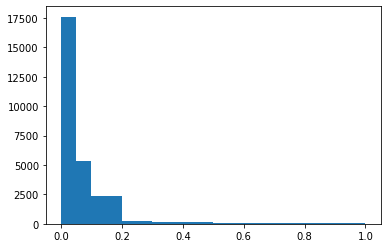

In [14]:
# Add a column with sizes in Mb - which is easier to read
all_emails['size_mb'] = all_emails['size'] / 1024 ** 2

_ = plt.hist(all_emails['size_mb'], bins=[0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1])
print(f'The median size is only {(all_emails["size"].median() / 1024):.2f} kb')

In [15]:
# Let's find out who are the most frequent senders:

all_emails['sender_norm'] = (all_emails['sender']
                           .str.extract('<?(\S+@\S+.\w+)>?', expand=False)
                           .str.lower()
                           .str.replace('"', '')
                           .str.replace('<', '')
                           .str.replace('[', ''))

top_senders = (all_emails.groupby('sender_norm')
           .agg({'sender_norm': ['count'], 'size_mb' : ['sum']})
           .sort_values(by=[('sender_norm', 'count')], ascending=False))

# Check the 10 senders that send most emails
top_senders.head(10)

,sender_norm,size_mb
,count,sum
sender_norm,,
drop@cointelegraph.com,834,62.743520
monit@vagas.com.br,735,9.187913
naoresponda@peixeurbano.com.br,662,56.461624
no-reply@e.udemymail.com,626,15.194730
udemy@email.udemy.com,613,51.604622
noreply@couchsurfing.com,578,17.019778
contato@sunoresearch.com.br,429,45.582200
contato@nordresearch.com.br,401,51.768979


In [24]:
# Now let's find out how many unread emails I have (shame on me)
all_emails['label_ids'] = all_emails['label_ids'].astype(str)
all_emails.loc[all_emails['label_ids'].str.contains('UNREAD', case=False), 'label_ids'] = 1

all_unread_emails = all_emails[all_emails.label_ids == '1' ]

len(all_unread_emails)

4134

In [25]:
top_unread_senders = (all_unread_emails.groupby('sender_norm')
           .agg({'sender_norm': ['count'], 'size_mb' : ['sum']})
           .sort_values(by=[('sender_norm', 'count')], ascending=False))

# Check the 15 senders that send most unread emails
top_unread_senders.head(30)

,sender_norm,size_mb
,count,sum
sender_norm,,
contato@nordresearch.com.br,246,31.638304
noreply@medium.com,194,19.746209
contato@sunoresearch.com.br,190,25.480583
drop@cointelegraph.com,164,13.611366
mercadobitcoin@info.mercadobitcoin.com.br,132,3.189160
digest-noreply@quora.com,127,13.264650
portuguese-digest-noreply@quora.com,126,13.295046
jobalerts-noreply@linkedin.com,125,8.272496


In [26]:
# Who is sending me the heaviest emails? (answer: myself)
top_senders.sort_values(by=[('size_mb', 'sum')], ascending=False).head(10)

,sender_norm,size_mb
,count,sum
sender_norm,,
gfraremusa@gmail.com,344,490.067822
pedrocaldaskimura@gmail.com,45,405.515455
cursodegaita@gmail.com,62,119.227383
tainaunb@hotmail.com,7,103.527739
yanne_cunha@hotmail.com,45,103.203647
julianomota11@gmail.com,13,95.328255
bel@mayaboard.com,17,87.166209
rcgarcia@unb.br,32,63.620435


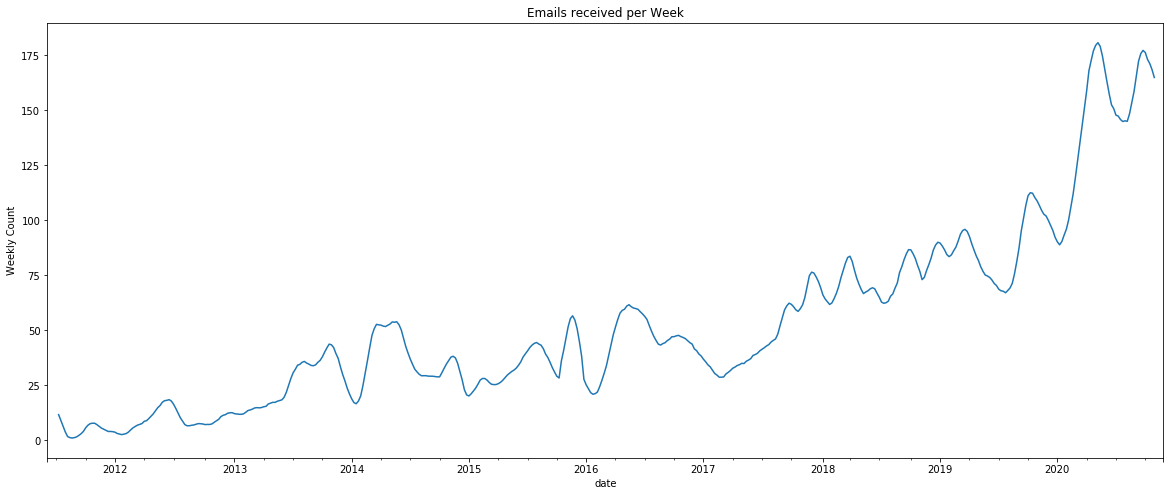

In [32]:
# Let's see how many emails I got weekly

all_emails = all_emails.set_index('date')

weekly_counts = all_emails.resample('W').count() # Get a count per week
# filter data from before gmail existed 
weekly_counts = weekly_counts[weekly_counts.index > np.datetime64('2004-04-01')] 
# Calculate the moving average
moving_av = weekly_counts.rolling(10, center=True, win_type='gaussian').mean(std=3)['id']

# plot it
fig, ax = plt.subplots(figsize=(20,8))
ax.set(xlabel='Date', ylabel='Weekly Count',
       title='Emails received per Week')
_ = moving_av.plot(ax=ax)

In [33]:
# Filter only emails from the 15 frequent senders:
top_sender_over_time = all_emails[all_emails['sender_norm'].isin(top_senders.head(15).index)]

# Group by sender and month and count
top_sender_over_time = (top_sender_over_time
                        .groupby(['sender_norm', pd.Grouper(level='date', freq='M')])
                        .agg({'sender_norm': ['count']}))

# "Unstack" the sender part of the index, so each sender gets his own column
top_sender_over_time = top_sender_over_time.unstack(level='sender_norm')

# Resample to make sure all periods have a value, even when no emails were recieved in that period
top_sender_over_time = top_sender_over_time.resample('M')

# Calculate the moving average the same way we did before    
top_sender_over_time = (top_sender_over_time.sum()
               .rolling(10, center=True, win_type='gaussian')
               .mean(std=3)
                       )

In [34]:
top_sender_over_time = top_sender_over_time['sender_norm']['count']

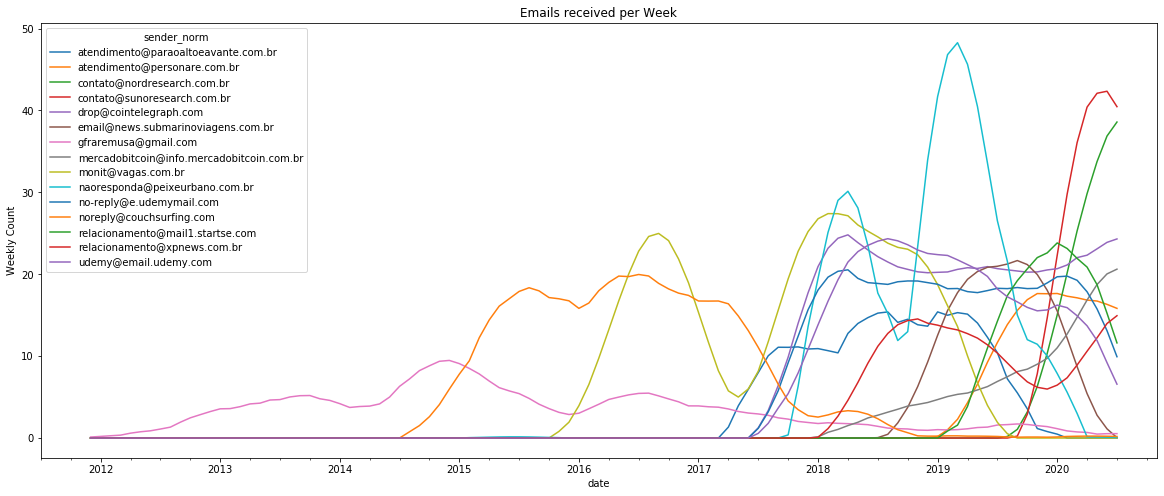

In [35]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set(xlabel='Date', ylabel='Weekly Count',
       title='Emails received per Week')
_ = top_sender_over_time.plot(ax=ax)

In [36]:
#Let's create a heatmap to understand the frequency growth from my top senders
top_sender_over_time_t = top_sender_over_time.transpose()
top_sender_over_time_t.columns = top_sender_over_time_t.columns.strftime('%Y-%m')

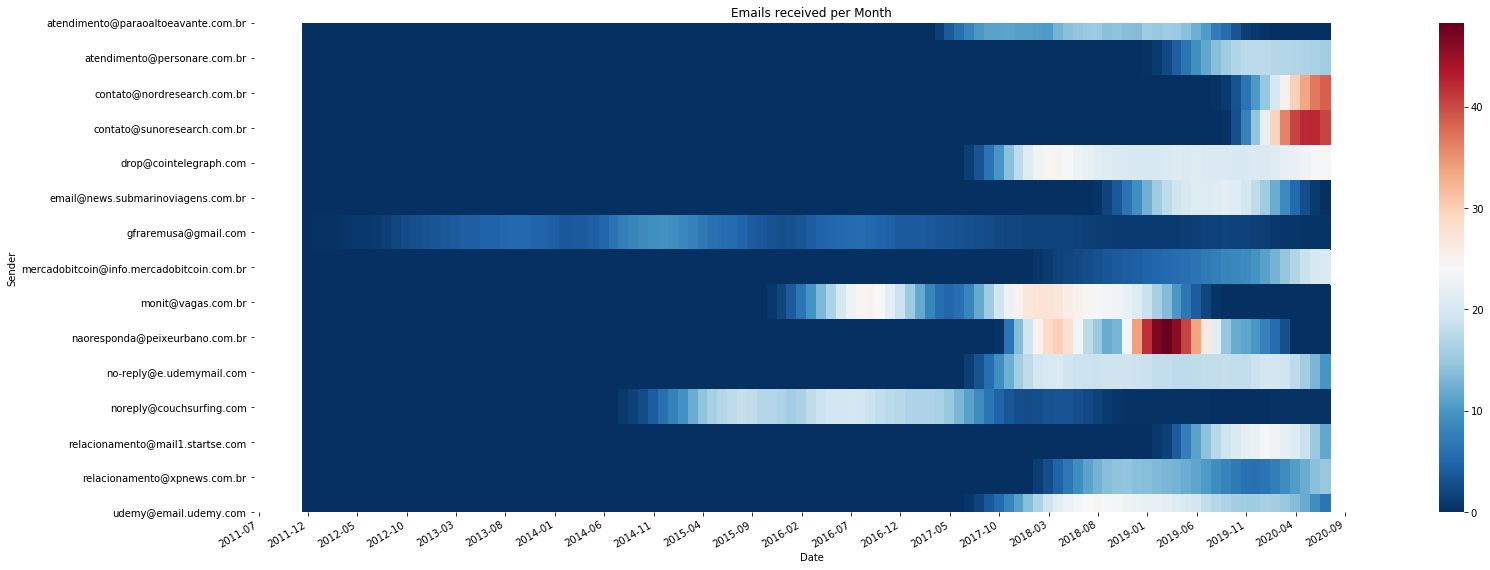

In [37]:
def plot_heatmap(df_to_plot, xlabel, ylabel, title):
    """Plots heatmap based of df_to_plot with some extra formatting"""
    fig, ax = plt.subplots(figsize=(25,10))

    ax = sns.heatmap(df_to_plot, ax=ax, xticklabels=True, cmap="RdBu_r")

    # I only want to see 1/5th of the orignal x axis labels for better readabilty
    xticks = ax.get_xticks()
    xtick_labels = ax.get_xticklabels()
    x_labels = [label for i, label in enumerate(xtick_labels) if i % 5 == 0]
    _ = ax.set_xticks([x for i, x in enumerate(xticks) if i % 5 == 0])
    _ = ax.set_xticklabels(x_labels)


    # The following formats the labels on the x-axis to be more readable
    _ = fig.autofmt_xdate()

    # Set axis labels and title
    _ = plt.ylabel(xlabel)
    _ = plt.xlabel(ylabel)
    _ = ax.set_title(title)
    
plot_heatmap(top_sender_over_time_t, 'Sender', 'Date', 'Emails received per Month')